training shape: (60000, 28, 28)
testing shape: (10000, 28, 28)
A few example images:


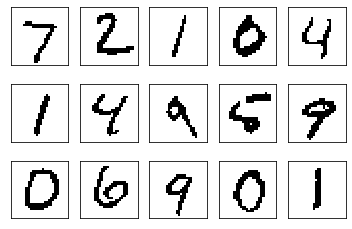

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib import pyplot as plt
import cv2

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print('training shape:', np.shape(x_train))
print('testing shape:', np.shape(x_test))
# The default image size is 28x28, but use line below to resize
d = 28

#convert images to 0/1 and resize
x_train_int = np.array([np.round(1.0*cv2.resize(i, (d,d))/256) for i in x_train]) 
x_test_int = np.array([np.round(1.0*cv2.resize(i, (d,d))/256) for i in x_test])

## function to plot images in grid
def show_images(images, rows, cols):
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray_r)
        plt.xticks(())
        plt.yticks(())
    plt.show()


## Uncomment below to see a few images
print('A few example images:')
show_images(x_test_int, 3, 5)


In [18]:
#### Training ###################

total_count = 2*np.ones((10,4,d,d))  #generate a list for counts of occurances
pixel_sums = np.ones((10,4,d,d))     #generate a list to sum occurances 

image_inds = [(i,j) for j in range(d) for i in range(d)] #create a tuple with all indexes of 28x28 image

for i, y in enumerate(y_train):
    #shift image up and create copy so that pixel below can be accessed with the same index
    pixel_below = np.vstack((x_train_int[i,1:,:], np.zeros((1,d)))).astype(int)
    #shift image to the right so that pixel to left can be accesses with same index
    pixel_left = np.hstack((np.zeros((d,1)), x_train_int[i,:,0:-1])).astype(int)
      
    #for i, binary_val in enumerate(binary_4):
    #    pixel_sums[y,i,:,:] = pixel_sums[y][i] + np.bitwise_xor(binary_val[0],f1_mask)\
    #      *np.bitwise_xor(binary_val[1],f3_mask)*x_train_int[i]
    #    total_count[y,i,:,:] = total_count[y][i]+ np.bitwise_xor(binary_val[0],f1_mask)\
    #      *np.bitwise_xor(binary_val[1],f3_mask)
        
    for ii, jj in image_inds:
        if pixel_below[ii,jj] == 0 and pixel_left[ii,jj] == 0:
            pixel_sums[y,0,ii,jj] = pixel_sums[y,0,ii,jj] + x_train_int[i,ii,jj]
            total_count[y,0,ii,jj] =  total_count[y,0,ii,jj] + 1
        if pixel_below[ii,jj] == 0 and pixel_left[ii,jj] == 1:
            pixel_sums[y,1,ii,jj] = pixel_sums[y,1,ii,jj] + x_train_int[i,ii,jj]
            total_count[y,1,ii,jj] =  total_count[y,1,ii,jj] + 1
        if pixel_below[ii,jj] == 1 and pixel_left[ii,jj] == 0:
            pixel_sums[y,2,ii,jj] = pixel_sums[y,2,ii,jj] + x_train_int[i,ii,jj]
            total_count[y,2,ii,jj] =  total_count[y,2,ii,jj] + 1
        if pixel_below[ii,jj] == 1 and pixel_left[ii,jj] == 1:
            pixel_sums[y,3,ii,jj] = pixel_sums[y,3,ii,jj] + x_train_int[i,ii,jj]
            total_count[y,3,ii,jj] =  total_count[y,3,ii,jj] + 1

In [19]:
#### Test ###################

errors = 0
for j, x in enumerate(x_test_int):
    pixel_below = np.vstack((x[1:,:], np.zeros((1,d)))).astype(int) 
    pixel_left = np.hstack((np.zeros((d,1)), x[:,0:-1])).astype(int)
    
    bayes_vec = np.zeros((10,1))
    for c in range(10):
        for ii, jj in image_inds:
            pix_val = x[ii,jj]
            if pixel_below[ii,jj] == 0 and pixel_left[ii,jj] == 0:
                if pix_val == 1:
                    bayes_vec[c] = bayes_vec[c]\
                          + np.log(pixel_sums[c,0,ii,jj]/total_count[c,0,ii,jj]) 
                else: 
                    bayes_vec[c] = bayes_vec[c]\
                          + np.log(1-pixel_sums[c,0,ii,jj]/total_count[c,0,ii,jj])
            if pixel_below[ii,jj] == 0 and pixel_left[ii,jj] == 1:
                if pix_val == 1:
                    bayes_vec[c] = bayes_vec[c]\
                          + np.log(pixel_sums[c,1,ii,jj]/total_count[c,1,ii,jj]) 
                else: 
                    bayes_vec[c] = bayes_vec[c]\
                          + np.log(1-pixel_sums[c,1,ii,jj]/total_count[c,1,ii,jj])  
            if pixel_below[ii,jj] == 1 and pixel_left[ii,jj] == 0:
                if pix_val == 1:
                    bayes_vec[c] = bayes_vec[c]\
                          + np.log(pixel_sums[c,2,ii,jj]/total_count[c,2,ii,jj]) 
                else: 
                    bayes_vec[c] = bayes_vec[c]\
                          + np.log(1-pixel_sums[c,2,ii,jj]/total_count[c,2,ii,jj])  
            if pixel_below[ii,jj] == 1 and pixel_left[ii,jj] == 1:
                if pix_val == 1:
                    bayes_vec[c] = bayes_vec[c]\
                          + np.log(pixel_sums[c,3,ii,jj]/total_count[c,3,ii,jj]) 
                else: 
                    bayes_vec[c] = bayes_vec[c]\
                          + np.log(1-pixel_sums[c,3,ii,jj]/total_count[c,3,ii,jj])                     
    prediction = np.argmax(bayes_vec)

    if prediction != y_test[j]:
        errors = errors+1
     
    if 1.0*j/100 == int(j/100):
        print(j)
        print('error count:', errors)
        
print('Error rate: ', errors/len(x_test_int))

0
error count: 0
100
error count: 5
200
error count: 9
300
error count: 16
400
error count: 26
500
error count: 37
600
error count: 47
700
error count: 55
800
error count: 67
900
error count: 77
1000
error count: 90
1100
error count: 98
1200
error count: 114
1300
error count: 129
1400
error count: 136
1500
error count: 143
1600
error count: 151
1700
error count: 159
1800
error count: 169
1900
error count: 176
2000
error count: 183
2100
error count: 192
2200
error count: 203
2300
error count: 211
2400
error count: 220
2500
error count: 227
2600
error count: 237
2700
error count: 251
2800
error count: 259
2900
error count: 266
3000
error count: 275
3100
error count: 280
3200
error count: 289
3300
error count: 295
3400
error count: 307
3500
error count: 314
3600
error count: 322
3700
error count: 327
3800
error count: 343
3900
error count: 355
4000
error count: 364
4100
error count: 377
4200
error count: 383
4300
error count: 396
4400
error count: 404
4500
error count: 416
4600
error coun

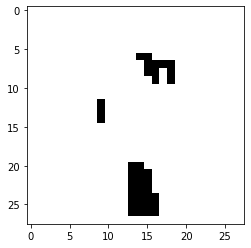

In [25]:
## acestral sampling (see 8.1 of CMP)
y_sample = 9
sample_image = np.zeros((d,d))
for ii, jj in image_inds:
    pixel_above = 0 if ii==0 else int(sample_image[ii-1,jj])
    pixel_left = 0 if jj==0 else int(sample_image[ii,jj-1])
    conditional = 2*pixel_above + pixel_left
    pixel_conditional = ((pixel_sums[y_sample, conditional, ii, jj]-1)/total_count[y_sample, conditional, ii, jj])
    if np.random.rand() <  pixel_conditional:
        sample_image[ii,jj] = 1
    else: 
        sample_image[ii,jj] = 0

plt.imshow(sample_image, cmap='gray_r')
plt.show()